In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import numpy as np

In [2]:
meta_df_all = pd.read_csv("../data/study2_movie/movie_regression_df.csv")

In [3]:
meta_df_all.averageRating.describe()

count    1104.000000
mean        6.926540
std         0.917431
min         2.400000
25%         6.400000
50%         7.000000
75%         7.600000
max         9.300000
Name: averageRating, dtype: float64

In [18]:
meta_df_all.network_density.describe()

count    1104.000000
mean        0.141241
std         0.079923
min         0.029989
25%         0.088319
50%         0.121212
75%         0.169322
max         0.666667
Name: network_density, dtype: float64

In [3]:
formula = "averageRating ~ n_nodes  + network_density + modularity  + average_clustering + " + \
             " + average_shortest_path_largest_component"
print(formula)

md = smf.ols(formula, meta_df_all)
mdf = md.fit()
print(mdf.summary())

averageRating ~ n_nodes  + network_density + modularity  + average_clustering +  + average_shortest_path_largest_component
                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     5.819
Date:                Wed, 19 Nov 2025   Prob (F-statistic):           2.59e-05
Time:                        22:57:52   Log-Likelihood:                -1456.4
No. Observations:                1104   AIC:                             2925.
Df Residuals:                    1098   BIC:                             2955.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|    

In [8]:
genres = ['drama', 'thriller','comedy','action','crime','romance',
 'scifi','horror','mystery','fantasy','family','animation','war','musical','western']

In [9]:
formula = "averageRating ~ n_nodes + network_density  + average_clustering + modularity  +  " + \
             " + average_shortest_path_largest_component + startYear + runtimeMinutes + isAdult + " +\
            " + ".join(["genre_"+g for g in genres])
print(formula)
md = smf.ols(formula, meta_df_all)
mdf = md.fit()
print(mdf.summary())

averageRating ~ n_nodes + network_density  + average_clustering + modularity  +   + average_shortest_path_largest_component + startYear + runtimeMinutes + isAdult + genre_drama + genre_thriller + genre_comedy + genre_action + genre_crime + genre_romance + genre_scifi + genre_horror + genre_mystery + genre_fantasy + genre_family + genre_animation + genre_war + genre_musical + genre_western
                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     22.82
Date:                Wed, 19 Nov 2025   Prob (F-statistic):           1.99e-74
Time:                        22:58:25   Log-Likelihood:                -1260.3
No. Observations:                1104   AIC:                             2567.
Df Residuals:                    1081   BIC:           

<Axes: >

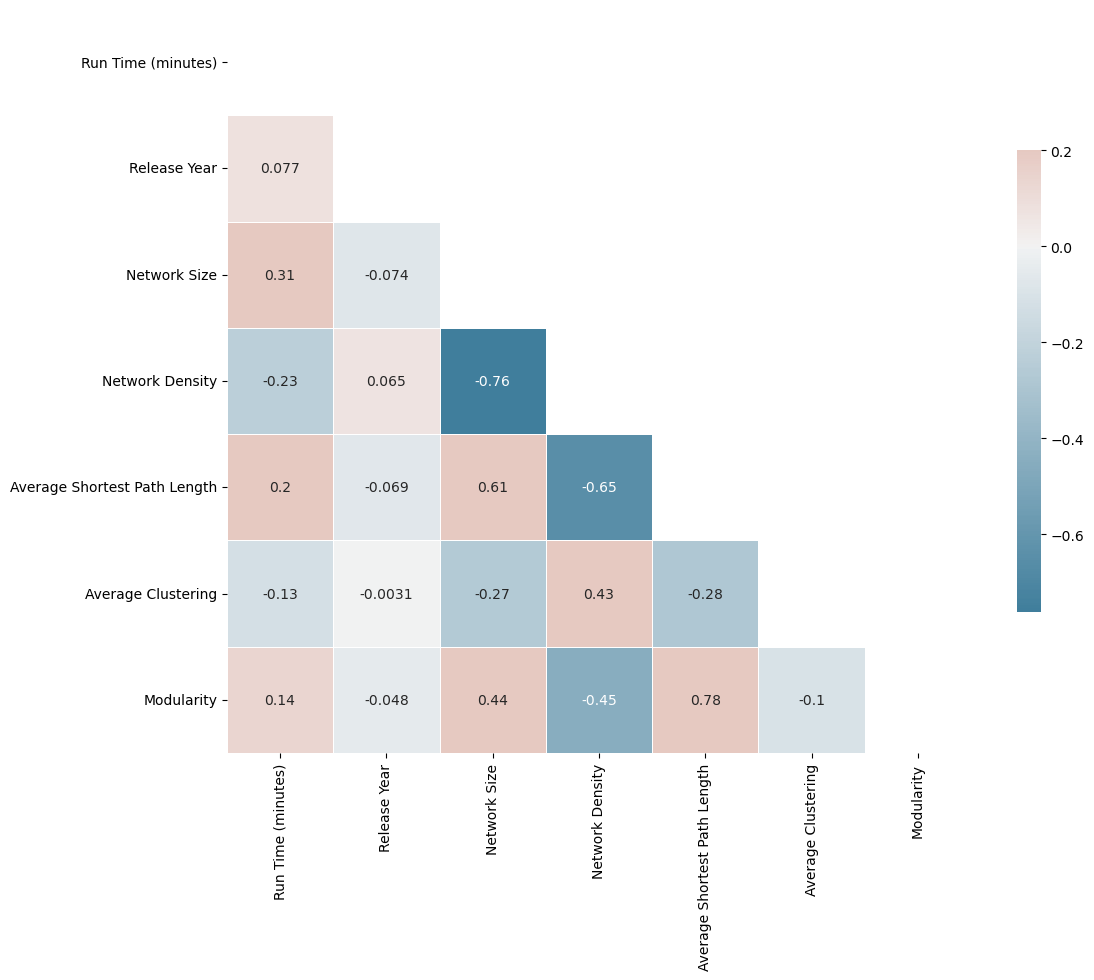

In [10]:
# Compute the correlation matrix
corr = meta_df_all[['runtimeMinutes', 'startYear',  'n_nodes',  'network_density',
                    'average_shortest_path_largest_component',
       'average_clustering', 
       'modularity', 
       ]].dropna().corr()
                        # "small_world_omega", "log_small_world_sigma",
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(12, 12))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

var_labels = ["Run Time (minutes)", "Release Year", "Network Size", "Network Density", "Average Shortest Path Length", "Average Clustering", "Modularity"]

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.2, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True,
           xticklabels=var_labels, yticklabels=var_labels)

[]

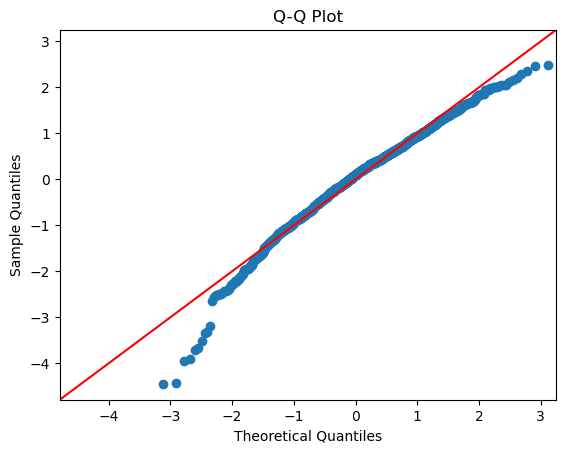

In [11]:
import statsmodels.api as sm
sm.qqplot(mdf.resid, fit=True, line="45")
plt.title('Q-Q Plot')
plt.plot()

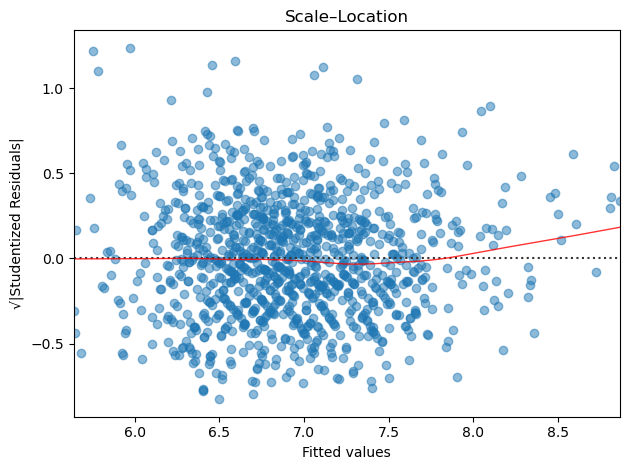

In [12]:
influence = mdf.get_influence()
studentized_resid = influence.resid_studentized_internal

sns.residplot(
    x=mdf.fittedvalues, 
    y=np.sqrt(np.abs(studentized_resid)),
    lowess=True,
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}
)
plt.title('Scale–Location')
plt.xlabel('Fitted values')
plt.ylabel('√|Studentized Residuals|')
# plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

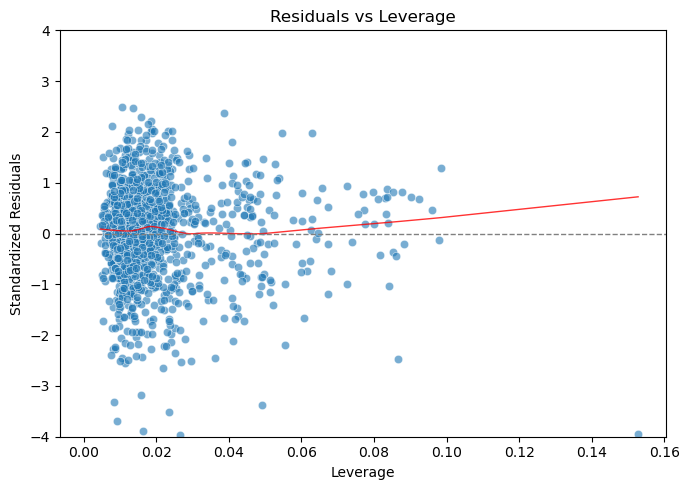

In [13]:
influence = mdf.get_influence()
leverage = influence.hat_matrix_diag
residuals = influence.resid_studentized_internal

# Compute Cook's distance and parameters
cooks_d = influence.cooks_distance[0]
p = mdf.df_model + 1

# Function for Cook’s D contour, clipped to avoid infinite values
def cooks_contour(c, p, leverage):
    leverage = np.clip(leverage, 1e-5, 1 - 1e-5)
    return np.sqrt((c * p * (1 - leverage)) / leverage)

# Plot
plt.figure(figsize=(7, 5))
sns.scatterplot(x=leverage, y=residuals, alpha=0.6)
sns.regplot(x=leverage, y=residuals, lowess=True,
            scatter=False, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.axhline(0, color='gray', linestyle='--', lw=1)
plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.title('Residuals vs Leverage')

# Add Cook’s distance contours (better scaling)
for c in [0.5, 1]:
    curve = cooks_contour(c, p, np.linspace(0.001, max(leverage), 50))
    plt.plot(np.linspace(0.001, max(leverage), 50), curve, 'r--', lw=1)
    plt.plot(np.linspace(0.001, max(leverage), 50), -curve, 'r--', lw=1)
    # plt.text(max(leverage)*0.98, cooks_contour(c, p, max(leverage)*0.98),
    #          f"Cook's D={c}", color='red', ha='right')
plt.ylim(-4, 4)
plt.tight_layout()
plt.show()

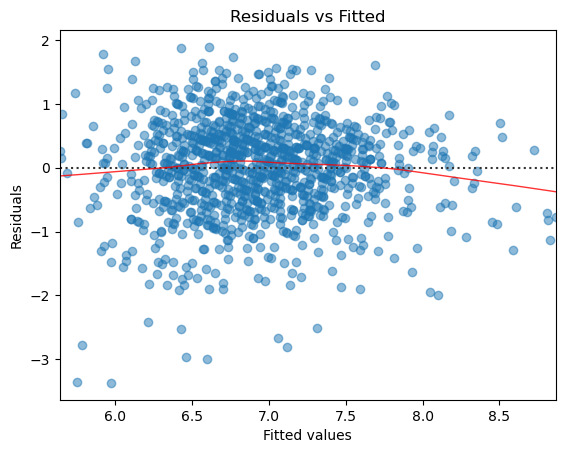

In [14]:

sns.residplot(x=mdf.fittedvalues, y=mdf.resid, 
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals');